In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import seaborn as sns
import numpy as np

In [3]:
faults = pd.read_csv('../data/J1939Faults.csv', index_col = 'RecordID', parse_dates = ['EventTimeStamp', 'LocationTimeStamp']) \
    .drop(columns = ['actionDescription', 'faultValue'])

diagnostics = pd.read_csv('../data/VehicleDiagnosticOnboardData.csv').pivot(index = 'FaultId', columns = 'Name', values = 'Value')

faults_diagnostics = faults.merge(diagnostics, left_on = 'RecordID', right_on = 'FaultId').set_index('EventTimeStamp').sort_index().reset_index()


C:\Users\Conrad\AppData\Local\Temp\ipykernel_27684\2533930152.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  faults = pd.read_csv('../data/J1939Faults.csv', index_col = 'RecordID', parse_dates = ['EventTimeStamp', 'LocationTimeStamp']) \


In [4]:
faults_diagnostics['EquipmentID'] = faults_diagnostics['EquipmentID'].astype(str)

In [5]:
derate_trucks_list = faults_diagnostics[faults_diagnostics['spn']==1569]['EquipmentID'].drop_duplicates().tolist()

#derate_trucks = derate_trucks.merge(faults_diagnostics)
derate_trucks = faults_diagnostics[faults_diagnostics['EquipmentID'].isin(derate_trucks_list)]

In [78]:
seven_days = datetime.timedelta(7)

all_derate_trucks = derate_trucks[:0]

for i in derate_trucks_list:
    
    derate_truck = derate_trucks[(derate_trucks['EquipmentID'] == i)]
    first_derate_time = derate_trucks[(derate_trucks['EquipmentID'] == i) & (derate_trucks['spn'] == 1569)].iloc[0]['EventTimeStamp']
    mask = (derate_truck['EventTimeStamp']<= first_derate_time) & (derate_truck['EventTimeStamp']>= first_derate_time - seven_days)
    derate_truck = derate_truck.loc[mask]
    derate_truck['diff'] = derate_truck['EventTimeStamp'] - derate_truck['EventTimeStamp'].shift(-1)
    derate_truck['diff'] = derate_truck['diff'].fillna(pd.Timedelta(seconds=0))
    derate_truck['diff'] = (derate_truck['diff']/np.timedelta64(1, 'h')).astype(float).abs()
    derate_truck = derate_truck.sort_values('EventTimeStamp', ascending=False)
    derate_truck['cumsum_diff'] = derate_truck['diff'].cumsum()
    derate_truck = derate_truck.sort_values('EventTimeStamp')
    all_derate_trucks = pd.concat([all_derate_trucks, derate_truck], ignore_index=True, sort=False)

In [79]:
all_derate_trucks

,EventTimeStamp,ESS_Id,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,...,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,diff,cumsum_diff
0,2000-03-19 13:02:36,108639840,Condition Exists Catalyst Dosing Unit Input Lines,04358814*06086133*051718174436*09401683*G1*BDR*,79923861,6X1u13D1500000000,CMMNS,0,3362,31,...,89.6,17407,False,NaN,65.25368,NaN,100,25.81,0.999444,0.999444
1,2000-03-19 14:02:34,108644439,Condition Exists Engine Protection Torque Derate,04358814*06086133*051718174436*09401683*G1*BDR*,79923861,6X1u13D1500000000,CMMNS,0,1569,31,...,84.2,18431,False,NaN,62.4381,NaN,100,25.81,0.000000,0.000000
2,2011-01-01 00:03:34,77308356,Condition Exists Engine Protection Torque Derate,05317106*04101156*020516150530*09400053*G1*BDR*,79743733,6X1u13D1500000000,CMMNS,0,1569,31,...,96.8,22527,False,NaN,9.689507,NaN,100,1.45,0.000000,0.000000
3,2011-01-01 00:03:34,77308358,NaN,05317106*04101156*020516150530*09400053*G1*BDR*,79743733,6X1u13D1500000000,CMMNS,0,5246,0,...,96.8,22527,False,NaN,9.689507,NaN,100,1.45,0.000000,0.000000
4,2011-01-01 00:03:29,13908742,NaN,04358814*06088094*061516161145*09401661*G1*BDR*,79909430,6X1u13D1500000000,CMMNS,0,5394,5,...,152.6,17407,True,NaN,0,NaN,100,0.29,0.041389,0.041389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9770,2020-01-09 13:23:38,116364731,High Voltage (Fuel Level),NaN,NaN,CECU3B-NAMUX4,PACCR,49,96,3,...,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN,8.004167,44.828889
9771,2020-01-09 21:23:53,116419454,Abnormal Frequency J1939 Network #2,NaN,NaN,CECU3B-NAMUX4,PACCR,49,1231,8,...,131,255,True,NaN,0,NaN,100,0,0.052222,36.824722
9772,2020-01-09 21:27:01,116419520,Abnormal Frequency J1939 Network #2,NaN,NaN,CECU3B-NAMUX4,PACCR,49,1231,8,...,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN,35.233333,36.772500
9773,2020-01-11 08:41:01,116585401,Low Voltage (Catalyst Dosing Unit),04358814*06011740*051718174436*09401683*G1*BDR*,79897853,6X1u13D1500000000,CMMNS,0,3361,4,...,93.2,17407,False,NaN,70.12756,NaN,100,10.44,1.539167,1.539167


In [80]:
all_derate_trucks['log_diff'] = np.log(all_derate_trucks['diff']+1)

<AxesSubplot:xlabel='diff', ylabel='Count'>

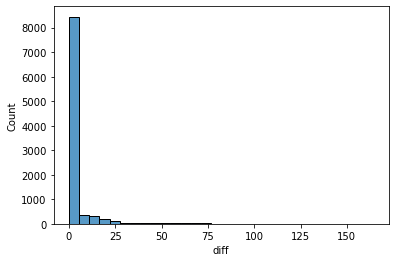

In [81]:
sns.histplot(data=all_derate_trucks, x = 'diff', bins=30)

<AxesSubplot:xlabel='log_diff', ylabel='Count'>

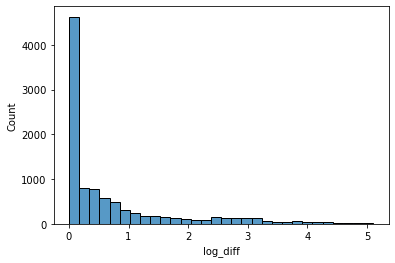

In [82]:
sns.histplot(data=all_derate_trucks, x = 'log_diff', bins = 30)

In [83]:
all_derate_trucks['spn'] = all_derate_trucks['spn'].astype(str)
day_notice = all_derate_trucks[all_derate_trucks['cumsum_diff'] <0]
spn_list = all_derate_trucks['spn'].unique()
spn_list

array(['3362', '1569', '5246', '5394', '641', '111', '102', '929', '627',
       '5848', '5743', '5851', '3226', '4334', '2791', '4364', '4344',
       '3031', '2863', '3610', '3251', '596', '3216', '81', '5397',
       '4342', '802', '3361', '803', '3363', '4096', '3703', '50353',
       '110', '1209', '723', '630', '100', '175', '3242', '3246', '3936',
       '1761', '4794', '3360', '4340', '5491', '245', '791', '611', '157',
       '3482', '171', '4094', '523531', '3556', '651', '1075', '4765',
       '829', '4363', '97', '3464', '1231', '101', '652', '91', '5742',
       '563', '411', '3058', '5019', '653', '444', '1807', '647', '1068',
       '639', '3060', '1808', '5031', '1172', '105', '168', '3218',
       '3228', '3509', '27', '51923', '190', '6802', '612', '5319', '629',
       '1045', '3597', '4376', '1483', '2623', '96', '5024', '789', '792',
       '29902', '1059', '3480', '3513', '84', '108', '807', '793', '1056',
       '1067', '795', '796', '1481', '1815', '3364', '248'

In [84]:
spn_stats = pd.DataFrame(all_derate_trucks[all_derate_trucks['spn'] == '1569']['cumsum_diff'].describe())

for i in spn_list:
    spn = all_derate_trucks[(all_derate_trucks['spn'] == i) & (all_derate_trucks['cumsum_diff'] != 0)]
    spn = spn.rename(columns={'cumsum_diff': i})
    spn = pd.DataFrame(spn[i].describe())
    spn_stats = spn_stats.merge(spn, left_index=True, right_index=True)

In [85]:
spn_stats = spn_stats.transpose().reset_index().rename(columns={'index':'spn'})[1:]


In [86]:
spn_stats = spn_stats[spn_stats['count'] > 1]

In [88]:
spn_stats.sort_values('count', ascending=False)

,spn,count,mean,std,min,25%,50%,75%,max
6,111,3211.0,80.834850,49.842773,0.026389,38.400278,79.855833,122.023472,167.980278
8,929,1636.0,76.849537,51.965658,0.005556,27.805833,68.377639,126.223889,167.584722
60,829,326.0,76.606974,47.318963,0.423889,36.478125,73.407500,121.764514,167.793056
43,1761,321.0,45.439682,57.267502,0.000278,1.374167,20.092222,66.177500,165.568333
100,96,303.0,77.525797,48.193931,1.538611,36.494583,68.521111,123.228333,167.793056
...,...,...,...,...,...,...,...,...,...
123,1675,2.0,3.052083,0.090549,2.988056,3.020069,3.052083,3.084097,3.116111
103,792,2.0,88.374167,8.418892,82.421111,85.397639,88.374167,91.350694,94.327222
81,5031,2.0,19.843333,23.067787,3.531944,11.687639,19.843333,27.999028,36.154722
127,3510,2.0,5.671250,1.453301,4.643611,5.157431,5.671250,6.185069,6.698889
